# Creating seperate DataFrames

To start, we'll read in our headline data with our clusters and create two DataFrames: one with points only in the United States, and all the points outside the US.

In [1]:
import pandas as pd
import numpy as np

df_world = pd.read_csv("data/clustered_headlines.csv")
df_us = df_world[df_world['countrycode']=='US']
df_world = df_world[df_world['countrycode']!='US']

In [2]:
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

world_plotter = Basemap()
# From Data Science Bookcamp: Plotting Maps using Basemap
us_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22,
                     urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)

In [3]:
# Helper function to eliminate redundant code while plotting cluster maps.
# Note that this function doesn't draw any countries/boundaries nor show the matplotlib map,
# so it is the caller's responsibility to plot the boundaries and map type they want.
def plot_clusters(data_frame, map_plotter):
    plt.figure(figsize=(20, 12))
    cluster_group = data_frame.groupby('cluster')
    for cluster_id, cluster in cluster_group:
        if cluster_id == -1: continue
        #map_plotter.scatter(np.array(cluster.longitude), np.array(cluster.latitude), latlon=True)
        map_plotter.scatter(cluster.longitude.to_numpy(), cluster.latitude.to_numpy(), latlon=True)
    plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )

# Re-clustering: World

Since the old clusters no longer apply to our dataset, we'll have to re-cluster both of our datasets, starting with the non-US points. For the world, we'll use the parameters `eps=9` and `min_samples=3`.

In [4]:
clusters = DBSCAN(eps=9, min_samples=3).fit_predict(df_world[['latitude', 'longitude']].to_numpy())
df_world['cluster'] = clusters

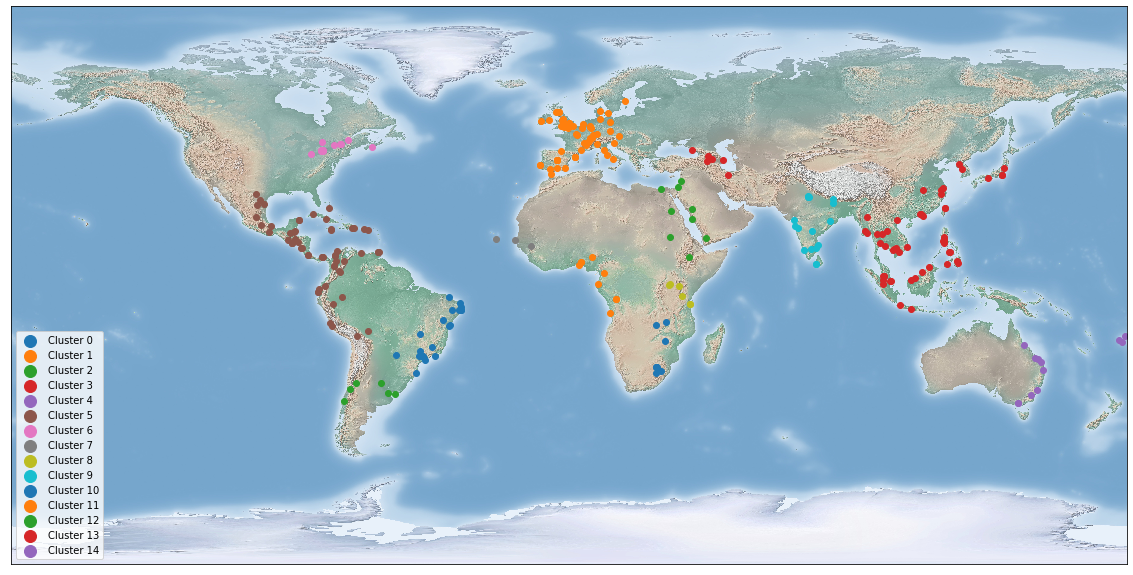

In [98]:
plot_clusters(df_world, world_plotter)
world_plotter.shadedrelief()
plt.show()

In [99]:
df_world.groupby('cluster').count().sort_values('headline', ascending=False)

,headline,city,latitude,longitude,countrycode,dist_from_center
cluster,,,,,,
1,63,63,63,63,63,63
3,61,61,61,61,61,61
5,58,58,58,58,58,58
0,21,21,21,21,21,21
-1,18,18,18,18,18,18
9,16,16,16,16,16,16
6,11,11,11,11,11,11
4,9,9,9,9,9,9
11,9,9,9,9,9,9


Looks good!

# Re-clustering: United States

Now, its time to recluster our United States data. We're probably going to try different parameters here, since the distance between cities is much smaller. Our starting parameters were `eps=2` and `min_samples=3`.

In [96]:
EPS = 1.25
MIN_SAMPLES = 3
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_us[['latitude', 'longitude']].to_numpy())
df_us['cluster'] = clusters

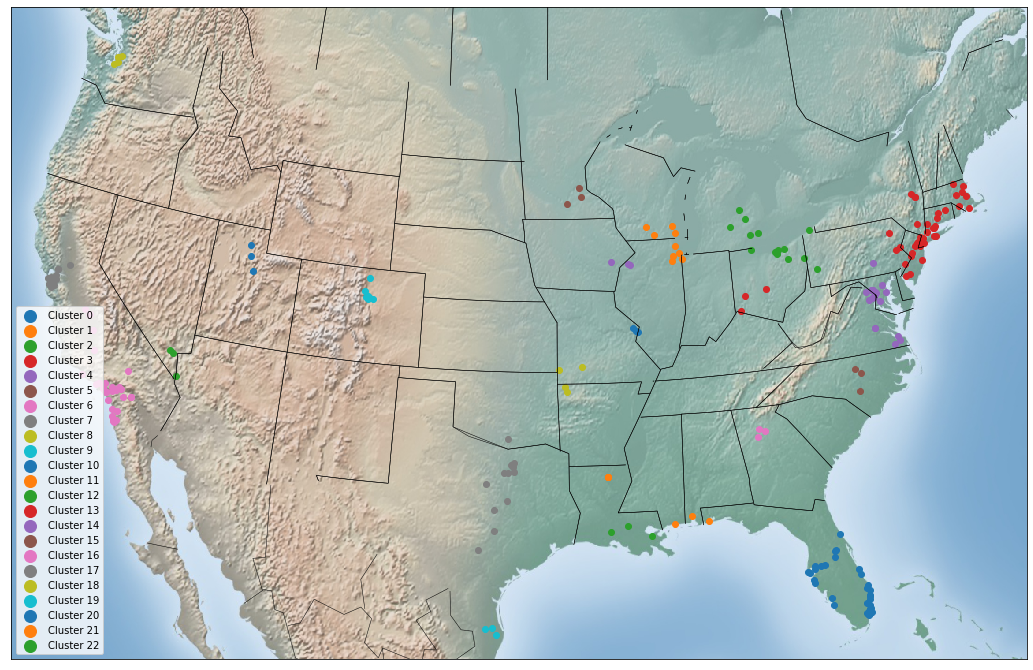

In [97]:
plot_clusters(df_us, us_plotter)
us_plotter.shadedrelief()
us_plotter.drawstates()
#plt.savefig(f"dbscan_{EPS}_{MIN_SAMPLES}.png", dpi=300, orientation="landscape")
plt.show()

In [8]:
df_us.groupby('cluster').count().sort_values('headline', ascending=False)

,headline,city,latitude,longitude,countrycode
cluster,,,,,
1,78,78,78,78,78
0,50,50,50,50,50
4,44,44,44,44,44
5,32,32,32,32,32
2,25,25,25,25,25
-1,23,23,23,23,23
6,15,15,15,15,15
8,7,7,7,7,7
7,6,6,6,6,6


# Finding Cluster Centers: Naïve Implementation

We'll find the center of each cluster for the US and World datasets, in order to locate headlines closet to the center of each cluster. For this verison, we'll do a simple average over all the Lat/Long points to represent the center.

In [9]:
us_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_us.groupby('cluster')}
world_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_world.groupby('cluster')}

In [10]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
import math
# DELETE BELOW NUMBA FOR RELEASE
from numba import jit
@jit(nopython=True) # DELETE ABOVE NUMBA FOR RELEASE
def great_circle(point_1, point_2):
    RADIUS = 6371  # Kilometers, Earth's mean radius
    lat_1 = math.radians(point_1[0])
    lat_2 = math.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = math.radians(point_2[1] - point_1[1])
    a = math.sin(d_lat/2)**2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(d_long/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return RADIUS * c

Next up, we'll create a new DataFrame to sort the headlines in each cluster by their proximity to the center we just calculated.

In [11]:
# TODO: Vectorize this...
# We'll do the US distances from their respective cluster centers first
dist_from_center = [great_circle((lat, lng), us_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_us.latitude, df_us.longitude, df_us.cluster)]
df_us['dist_from_center'] = dist_from_center

# Next up are the world distances from their respective cluster centers
dist_from_center = [great_circle((lat, lng), world_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_world.latitude, df_world.longitude, df_world.cluster)]
df_world['dist_from_center'] = dist_from_center

In [20]:
df_us.sort_values(by=['cluster', 'dist_from_center'], inplace=True)
df_world.sort_values(by=['cluster', 'dist_from_center'], inplace=True)

# Examining Headlines

With the data now sorted by closest point to the center of each cluster, we can now examine the data to see if there are trends of certain outbreaks in each cluster. From there, we can start noting common diseases.

In [75]:
known_diseases = set( ["Zika", r"Hepatitis [A-E]"] )
# Possible diseases
known_diseases.update( ["Norovirus", "Mumps", "Chlamydia", "Measles"] )

In [76]:
pd.set_option('display.max_colwidth', -1)
df_us[(df_us.cluster == 5)]

,headline,city,latitude,longitude,countrycode,cluster,dist_from_center
196,The Spread of Chikungunya in Arcadia has been Confirmed,Arcadia,34.13973,-118.03534,US,5,14.498473
193,Zika Virus Arrives in Ontario,Ontario,34.06334,-117.65089,US,5,21.944470
357,Norwalk Encounters Severe Symptoms of Malaria,Norwalk,33.90224,-118.08173,US,5,30.233610
527,Gonorrhea Exposure in Norwalk,Norwalk,33.90224,-118.08173,US,5,30.233610
551,Norovirus Vaccine is now Required in Anaheim,Anaheim,33.83529,-117.91450,US,5,31.462599
241,More Patients in Orange are Getting Diagnosed with Chickenpox,Orange,33.78779,-117.85311,US,5,36.671416
358,Zika arrives in Orange City,Orange,33.78779,-117.85311,US,5,36.671416
548,Authorities are Worried about the Spread of Mumps in Corona,Corona,33.87529,-117.56644,US,5,39.475711
96,Hollywood Outbreak Film Premieres,Hollywood,34.09834,-118.32674,US,5,41.156108
245,Zika symptoms spotted in Hollywood,Hollywood,34.09834,-118.32674,US,5,41.156108


In [74]:
df_us[(df_us.cluster == 4) & (df_us.headline.str.contains("Malaria"))]

,headline,city,latitude,longitude,countrycode,cluster,dist_from_center
588,Malaria Vaccine is now Required in Elyria,Elyria,41.36838,-82.10765,US,4,349.364660
523,Malaria Vaccine is now Required in Winona,Winona,44.04996,-91.63932,US,4,531.384571
